# Weekly exercise
This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images. It is recommended that you finish the exercises from Monday before continuing with the weekly project.

The image sets are found in the attached zip-file. Start with the rs.zip and move on to mynteye.zip once you have it working. The physical dimensions of each square of the pattern are 33.6 x 33.6 mm.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

## Using Exercise 1- script as template
Main 3 steps: 1) find chessboard-corners in a dataset of images containing a chessboard. 2) Use the corner points to compute a camera matrix. 3) Use the camera matrix to undistort images.



Use any of the images in the folder `imgs` to extract the number of checkerboard corners there are on the checkerboard. Fill in the information in `nb_vertical` and `nb_horizontal` and look up the opencv `findChessboardCorners` function and implement it in the below code snippet .

In [2]:
nb_vertical = 6
nb_horizontal = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

#mynteye

images = glob.glob('rs/left*.png')
assert images

for fname in images:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

ret_left, mtx_left, dist_left, rvecs_left, tvecs_left = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img_left = cv2.imread('rs/left-0010.png')
h,  w = img.shape[:2]
cammat_left, roi_left = cv2.getOptimalNewCameraMatrix(mtx_left,dist_left,(w,h),1,(w,h))
print (cammat_left)

[[366.46514893   0.         325.13521861]
 [  0.         367.27105713 247.98819868]
 [  0.           0.           1.        ]]


Do the same for the right image

In [3]:
nb_vertical = 6
nb_horizontal = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('rs/right*.png')
assert images

for fname in images:
    img = cv2.imread(fname)
    h, w = img.shape[:2]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img, (nb_vertical,nb_horizontal),  None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nb_vertical,nb_horizontal), corners,ret)
        cv2.imshow('img',img)
        cv2.waitKey(50)

cv2.destroyAllWindows()

ret_right, mtx_right, dist_right, rvecs_right, tvecs_right = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
img_right = cv2.imread('rs/right-0010.png')
h,  w = img.shape[:2]
cammat_right, roi_right = cv2.getOptimalNewCameraMatrix(mtx_right,dist_right,(w,h),1,(w,h))
print (cammat_right)

[[368.80545044   0.         323.23753744]
 [  0.         369.61694336 246.36468556]
 [  0.           0.           1.        ]]


Text(0.5, 1.0, 'Undistorted image')

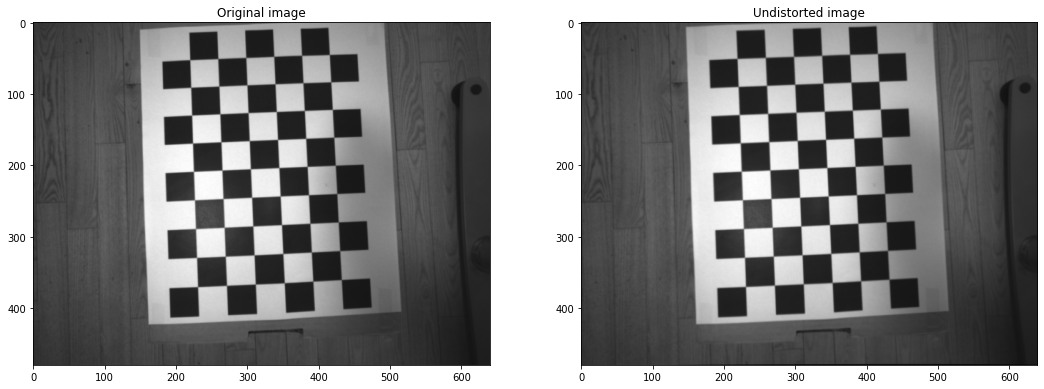

In [4]:
# undistort left
dst_left = cv2.undistort(img_left, mtx_left, dist_left, None, None)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img_left[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst_left[...,[2,1,0]])
ax[1].set_title('Undistorted image')

Text(0.5, 1.0, 'Undistorted image')

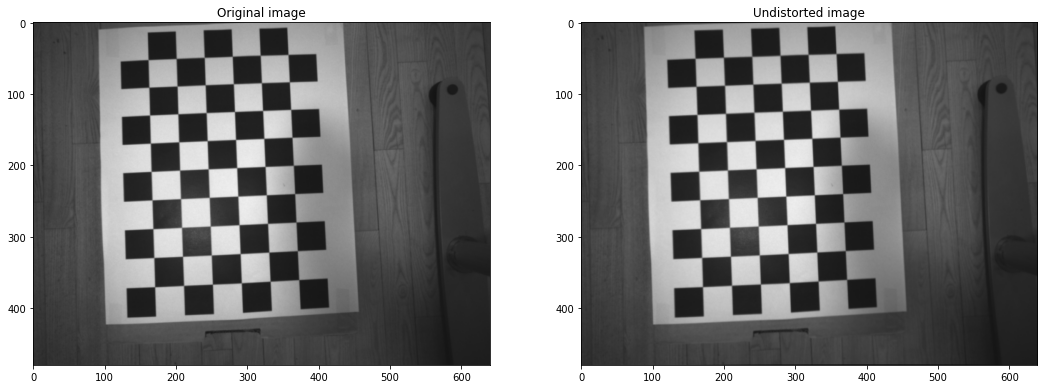

In [5]:
# undistort right
dst_right = cv2.undistort(img_right, mtx_right, dist_right, None, None)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(img_right[...,[2,1,0]])
ax[0].set_title('Original image')
ax[1].imshow(dst_right[...,[2,1,0]])
ax[1].set_title('Undistorted image')

(4, 4, 633, 474)


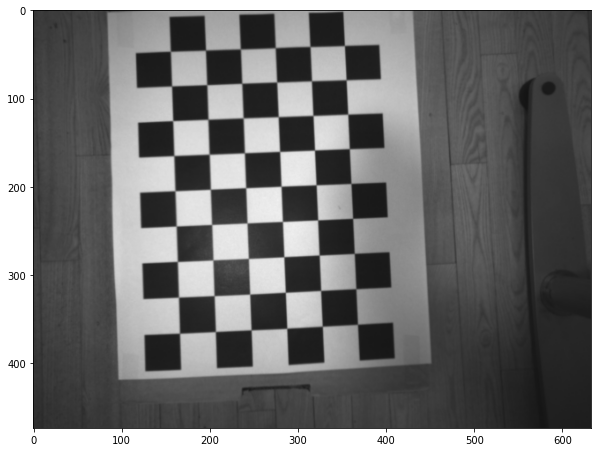

In [6]:
# crop the image
print(roi_right)
x,y,w,h = roi_right
dst_right = dst_right[y:y+h, x:x+w]
plt.figure(figsize=(10,10))
plt.imshow(dst_right[...,[2,1,0]])

In [17]:
img1 = dst_left
img2 = dst_right

sift = cv2.xfeatures2d.SIFT_create()

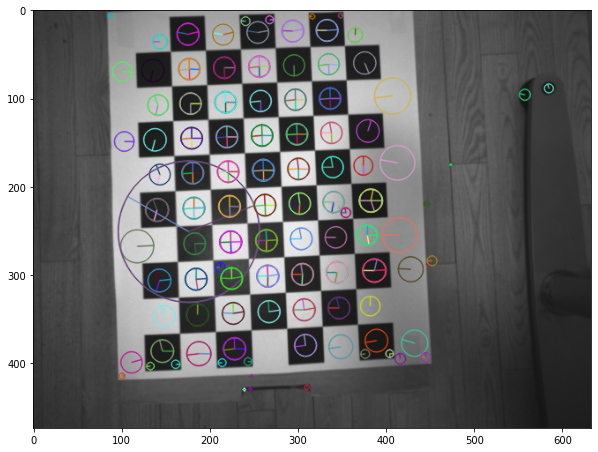

In [18]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

kp_img = cv2.drawKeypoints(img2, kp2, img2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize = (10,10))
plt.imshow(kp_img)

bf = cv2.BFMatcher()
matches = bf.match(des1,des2)

# Sort them in the order of their distance (i.e. best matches first).
matches = sorted(matches, key = lambda x:x.distance)

In [27]:
nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
    

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [28]:
F

array([[-2.20743686e-06,  2.40751625e-06,  1.89891398e-02],
       [-2.42174713e-06,  3.36608851e-09,  8.96218960e-06],
       [-1.77513336e-02,  1.43028370e-04,  1.00000000e+00]])

In [29]:
E = np.dot( np.dot(np.transpose(cammat_right), F), cammat_left)

In [31]:
print(E)

[[-2.98344681e-01  3.26101850e-01  6.95879089e+00]
 [-3.28029834e-01  4.56945187e-04 -2.87413522e-01]
 [-6.98537289e+00  3.38644952e-01  1.17130738e+00]]


In [34]:
U,S,V = np.linalg.svd(E, full_matrices=False)

In [37]:
print('U:')
print(U)
print('S:')
print(S)
print('V:')
print(V)

U:
[[-0.67796818  0.73342659 -0.04944266]
 [-0.00247341 -0.06953622 -0.99757636]
 [-0.73508709 -0.67620274  0.04895741]]
S:
[7.73499492e+00 6.26596060e+00 3.83802677e-11]
V:
[[ 0.69010219 -0.06076557 -0.72115637]
 [ 0.7225587   0.00161944  0.69130768]
 [-0.04083983 -0.99815075  0.04502427]]


In [39]:
W = np.asarray([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

In [57]:
R = np.dot(U,np.dot(np.linalg.inv(W),np.transpose(V)))

t = np.dot(np.dot(np.dot(U,np.linalg.inv(W)),S),np.transpose(U))

In [58]:
print('R:')
print(R)
print('t:')
print(t)

R:
[[-0.42928629 -0.56522178  0.70444135]
 [ 0.76754594 -0.6393922  -0.04528616]
 [ 0.47601103  0.52125037  0.70831599]]
t:
[ 7.07848336 -0.63466885  6.97027097]


In [59]:
print(np.linalg.det(R))

0.9999999999999999


In [62]:
print((w,h))

(633, 474)


In [70]:
retval, H1, H2 = cv2.stereoRectifyUncalibrated(corner,pts2,F,(w,h))

In [71]:
H1

array([[-4.25030200e-04,  1.63355865e-02,  1.90035673e+00],
       [-1.88807974e-02,  1.42636846e-03,  1.11226113e+01],
       [-2.01929346e-06,  2.32607368e-06,  1.83475916e-02]])

In [74]:
dst1 = cv2.warpPerspective(img1, H1, (w,h))
dst2 = cv2.warpPerspective(img2, H2, (w,h))

In [84]:
ret1, corners1 = cv2.findChessboardCorners(img_right, (nb_vertical,nb_horizontal))
ret2, corners2 = cv2.findChessboardCorners(img_left, (nb_vertical,nb_horizontal))

'''
nb_matches = 200

good = []
pts1 = []
pts2 = []

for m in matches[:nb_matches]:
    good.append(m)
    pts1.append(kp1[m.queryIdx].pt)
    pts2.append(kp2[m.trainIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

'''

F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# We select only inlier points
pts1 = corners1[mask.ravel() == 1]
pts2 = corners2[mask.ravel() == 1]


retval, H1, H2 = cv2.stereoRectifyUncalibrated(pts1,pts2,F,(w,h))

dst1 = cv2.warpPerspective(img_right, H1, (w,h))
dst2 = cv2.warpPerspective(img_left, H2, (w,h))


Text(0.5, 1.0, 'Undistorted image')

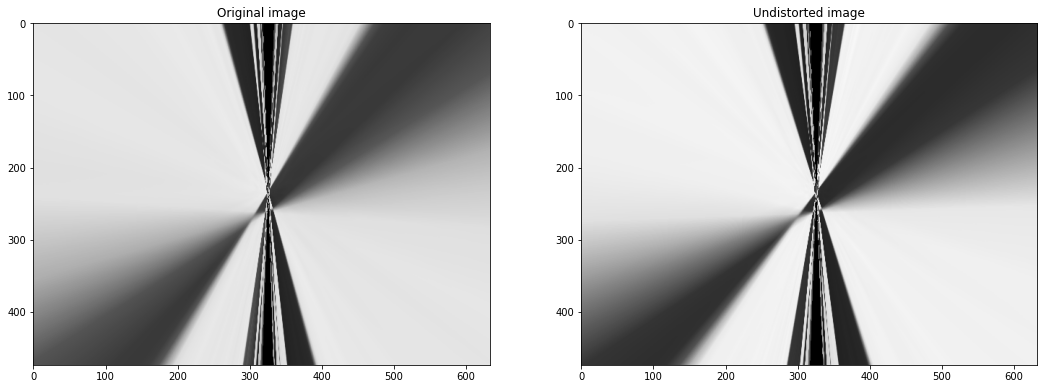

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(dst1)
ax[0].set_title('Original image')
ax[1].imshow(dst2)
ax[1].set_title('Undistorted image')